# 🏷️ Part 1.3 – Categorizing Job Titles Using Unsupervised Learning

**Author:** Yu Kyung Koh  
**Last Updated:** July 5, 2025

---

### 🎯 Objective

* This notebook applies **unsupervised machine learning** methods—including **k-means clustering** and **Latent Dirichlet Allocation (LDA)**—to group job titles based on text similarity.
* In unsupervised learning, the model identifies patterns or structures in the data **without access to** labeled examples.
  * This differs from **supervised learning** used in the previous section, where the model is trained on input–output pairs (e.g., job titles and their known categories) and learns to predict labels based on those examples.
  * Unsupervised approach is useful when labeled data is unavailable, costly to obtain, or when the goal is to explore natural groupings or themes in the dataset.
* I also test how the results differ when using TF-IDF vs Embeddings for clustering
* Although in my data the job category labels are known by design (assigned during the synthetic job posting generation using LLMs — [see details here](https://github.com/yukyungkoh/job-postings-data-project/tree/main/0_generate-synthetic-job-postings)), they are treated as **unknown** during model training and used only for post-hoc evaluation.

---

### 🗂️ Outline

- **Section 1:** Prepare and preprocess the job posting data  
- **Section 2:** K-means Clustering – Based on TF-IDF  
- **Section 3:** K-means Clustering – Based on Embeddings  
- **Section 4:** Topic Modeling – Latent Dirichlet Allocation (LDA)

---
## SECTION 1: Prepare and preprocess the job posting data

In [3]:
import pandas as pd
import numpy as np
import os
import re
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
from gensim import corpora
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.tokenize import TreebankWordTokenizer
import nltk

nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)


True

In [4]:
# --------------------------------------
# STEP 1: Import data and clean
# --------------------------------------
datadir = '../data/'
jobposting_file = os.path.join(datadir, 'synthetic_job_postings_combined.csv')

posting_df = pd.read_csv(jobposting_file)

posting_df.head() 

,job_title,posting_text,sector
0,Sales Development Representative,Join a dynamic team dedicated to driving innov...,sales
1,Healthcare Data Analyst,Join a dynamic team dedicated to improving pat...,healthcare
2,Data Insights Specialist,Join a dynamic team dedicated to unlocking the...,data science
3,Digital Content Strategist,"At our innovative marketing agency, we believe...",marketing
4,Curriculum Developer,Join a dynamic team dedicated to transforming ...,education


In [5]:
## Rename "sector" as "true_category"
posting_df.rename(columns={'sector': 'true_category'}, inplace=True)

In [6]:
## Combine job title and job description 
posting_df['all_text'] = posting_df['job_title'].fillna('') + ' ' + posting_df['posting_text'].fillna('')

In [7]:
# --------------------------------------
# STEP 2: Lowercase, tokenize, and POS-tag
# --------------------------------------
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('averaged_perceptron_tagger_eng', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

# Initialize tokenizer and stopwords
tokenizer = TreebankWordTokenizer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Add custom stopwords
custom_stopwords = {"please", "required", "make", "look"}  # Add any custom terms that are not informative about underlying topics
stop_words.update(custom_stopwords)

# Helper: convert NLTK POS tag to WordNet POS tag (Necessary to perform accurate lemmatization using WordNetLemmatizer)
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # default fallback


# Define the full preprocessing function
def preprocess(text):
     # Step 1: Lowercase and tokenize
    tokens = tokenizer.tokenize(text.lower())

    # Step 2: Remove non-alphabetic tokens
    tokens = [word for word in tokens if word.isalpha()]

    # Step 3: POS tagging
    tagged = nltk.pos_tag(tokens)

    # Step 4: Lemmatize (keep nouns and verbs)
    lemmatized = [
        lemmatizer.lemmatize(word, get_wordnet_pos(pos))
        for word, pos in tagged
        if pos.startswith('NN') or pos.startswith('VB')
    ]

    # Step 5: Remove stopwords after lemmatization
    lemmatized = [word for word in lemmatized if word not in stop_words]

    return lemmatized

# Apply preprocessing to all job postings
tokenized_docs = posting_df['all_text'].fillna('').apply(preprocess)

---
## SECTION 2: K-means clustering - Based on TF-IDF

In this section, I will use the K-means clustering method to categorize job postings to 11 distinct categories.

K-means clustering is an unsupervised learning algorithm that partitions data into **K distinct clusters** based on feature similarity.

- Here, I apply K-Means to the **TF-IDF representations** of job postings.
- Each posting is represented as a vector of word importance scores (TF-IDF).
- The algorithm groups similar postings together by minimizing the distance to a cluster center (centroid).

Once clustered, we can interpret the topics or themes of each cluster by visualizing the most frequent job titles using a word cloud.

In [9]:
# --------------------------------------
# STEP 1: Vectorize Text with TF-IDF
# --------------------------------------
## Note: 
##  - K-means only works on numerical data. Hence, need to convert text into numerical representations

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000, 
                             stop_words='english', 
                             ngram_range=(1, 2))
X_tfidf = vectorizer.fit_transform(posting_df['all_text'])
print(X_tfidf.shape)  ## (123849, 10000) => 123849 postings and 10000 most important uni/bigrams 

(9463, 1000)


In [10]:
# --------------------------------------
# STEP 2: Apply K-Means
# --------------------------------------
from sklearn.cluster import KMeans

k = 11  # 11 clusters
kmeans_tfidf = KMeans(n_clusters=k, random_state=42)
posting_df['kmeans_tfidf_cluster'] = kmeans_tfidf.fit_predict(X_tfidf)

🔹 Top most common titles per cluster - K-means using TF-IDF:


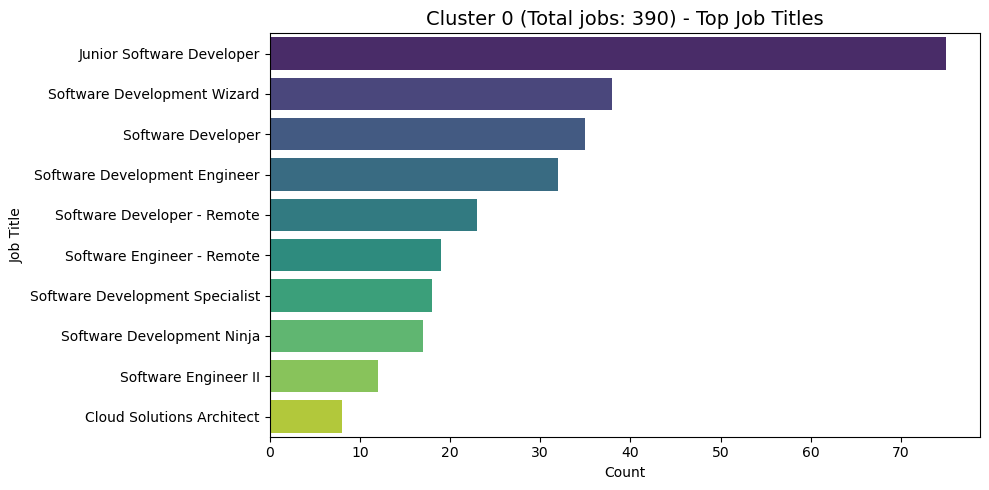

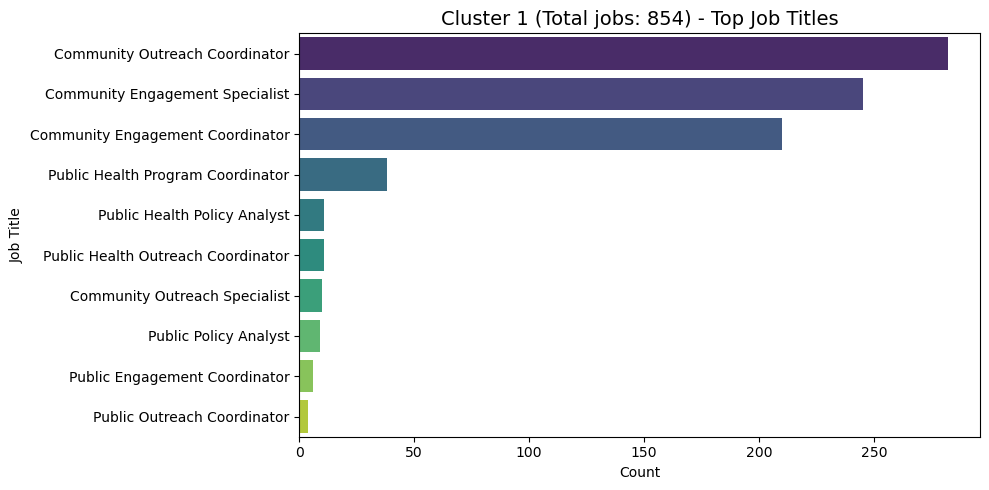

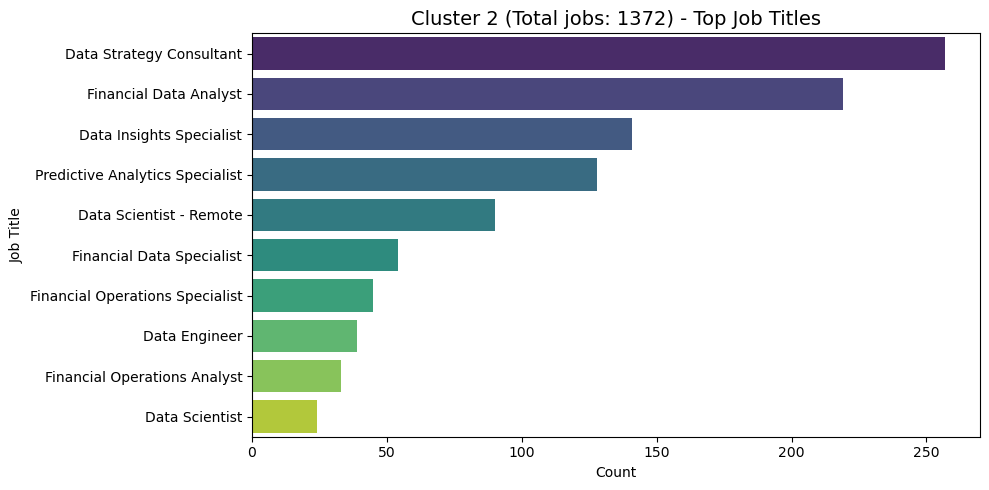

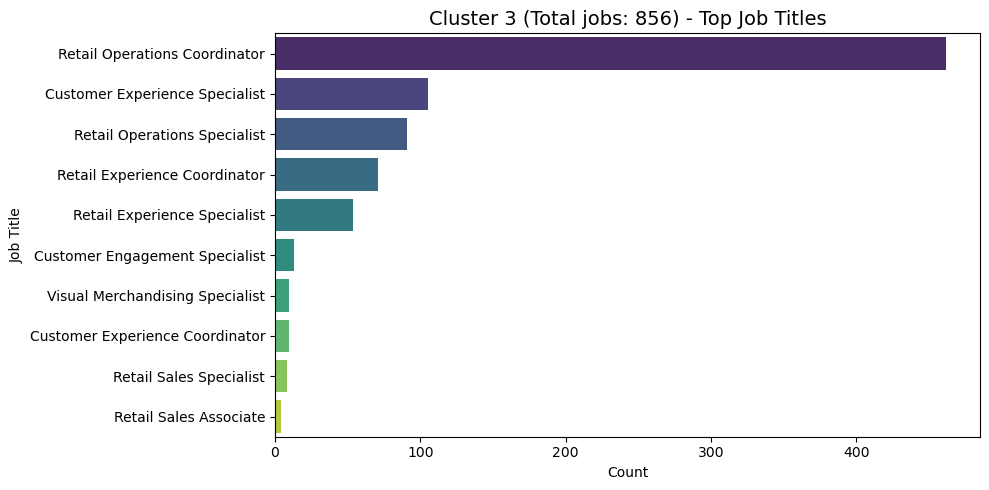

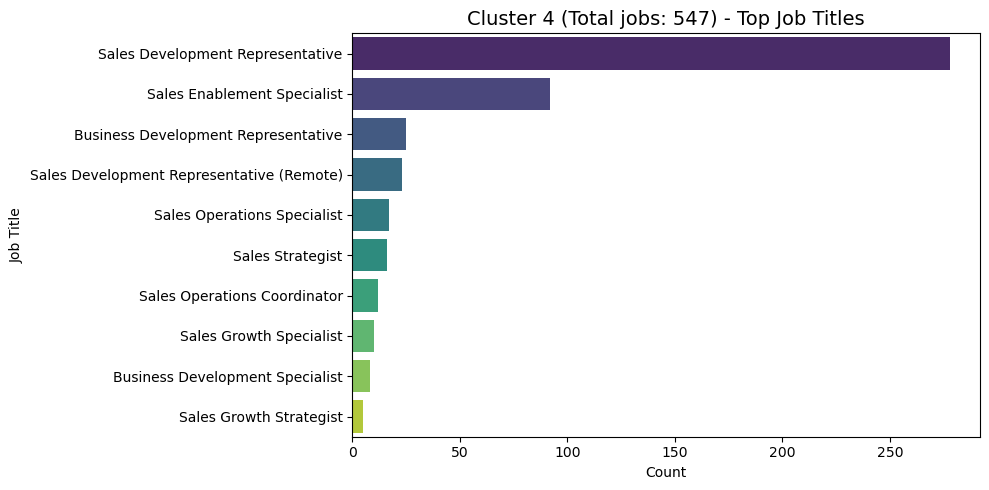

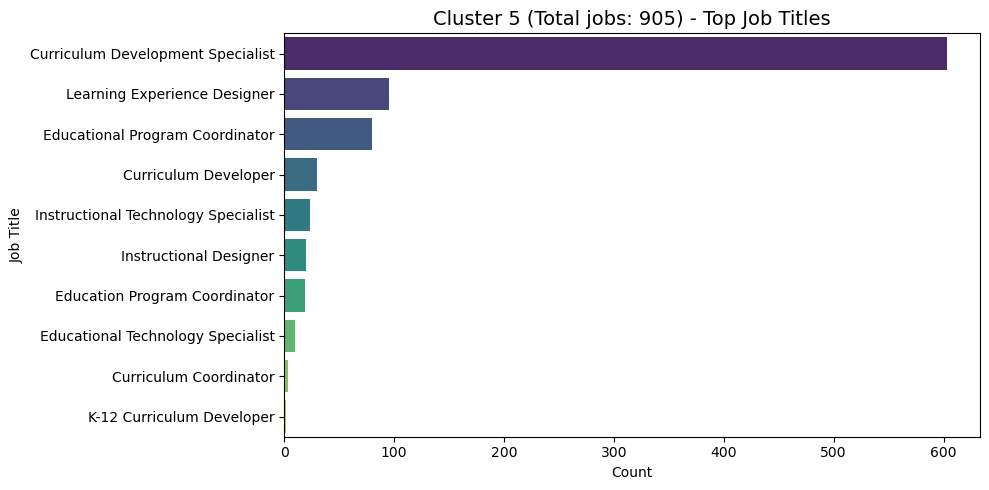

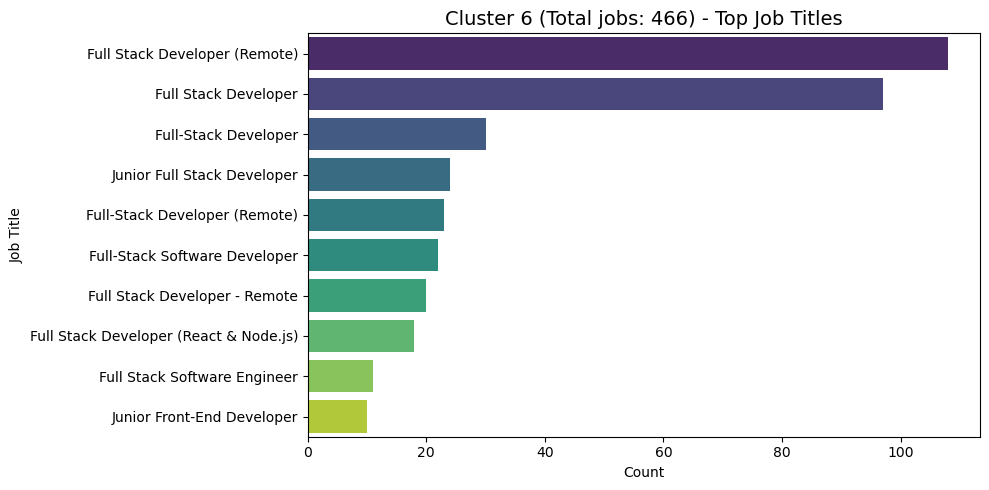

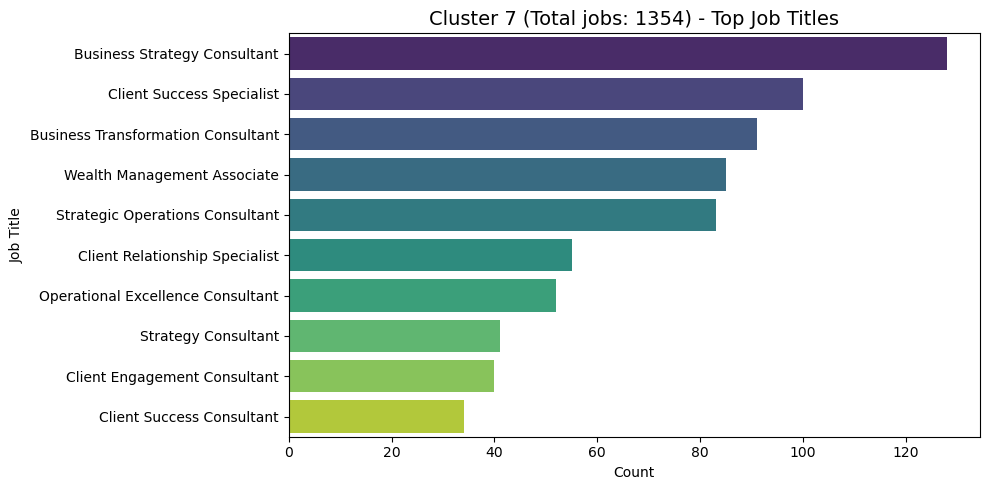

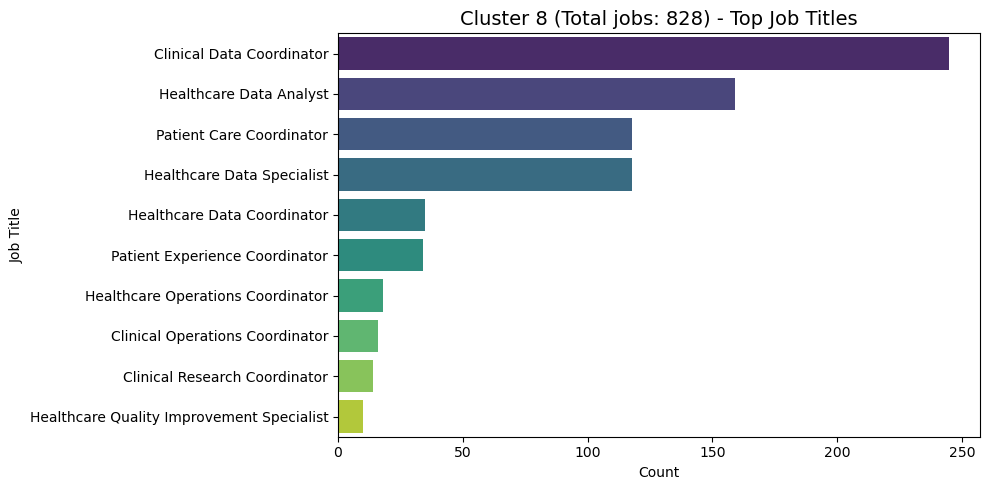

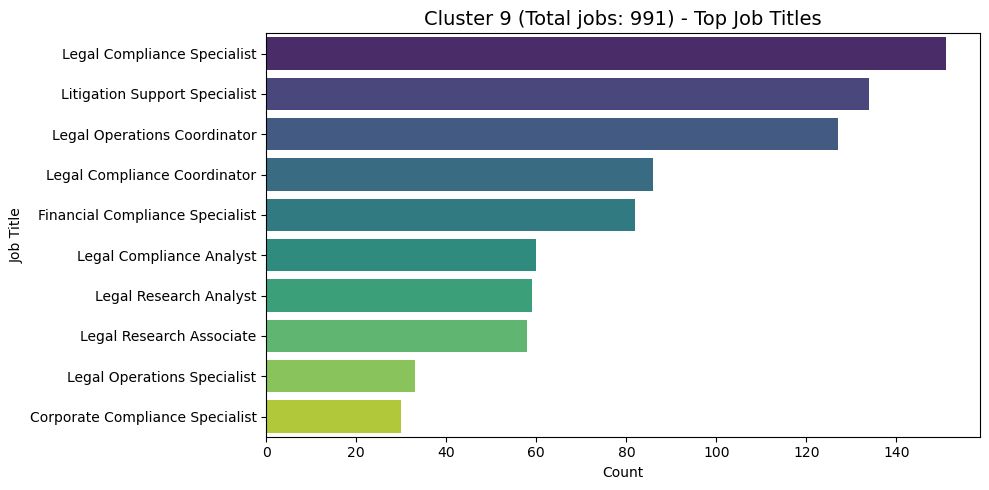

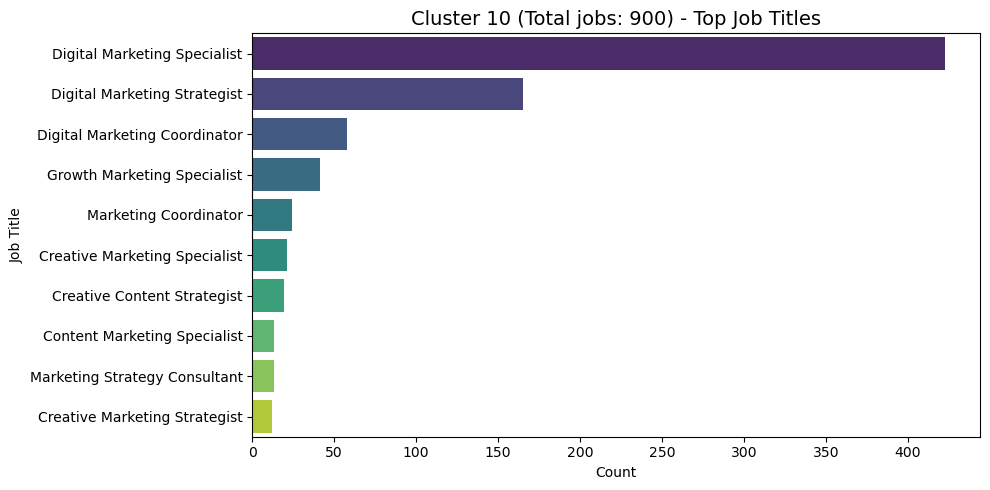

In [11]:
# --------------------------------------
# STEP 3: Examine Cluster Results 
# --------------------------------------
# Top job titles in each cluster
print("🔹 Top most common titles per cluster - K-means using TF-IDF:")
for i in range(k):
    cluster_df = posting_df[posting_df['kmeans_tfidf_cluster'] == i]
    total_in_cluster = len(cluster_df)
    
    top_titles = cluster_df['job_title'].value_counts().head(10)

    plt.figure(figsize=(10, 5))
    sns.barplot(x=top_titles.values, y=top_titles.index, palette='viridis', hue=top_titles.index, legend=False)
    plt.title(f"Cluster {i} (Total jobs: {total_in_cluster}) - Top Job Titles", fontsize=14)
    plt.xlabel("Count")
    plt.ylabel("Job Title")
    plt.tight_layout()
    plt.show()

In [12]:
## Counting the number of job postings in each cluster
posting_df['kmeans_tfidf_cluster'].value_counts()

kmeans_tfidf_cluster
2     1372
7     1354
9      991
5      905
10     900
3      856
1      854
8      828
4      547
6      466
0      390
Name: count, dtype: int64

In [13]:
# --------------------------------------
# STEP 4: Inspect words per cluster
# --------------------------------------
##  Here, I print out the top 10 most important terms associated with each cluster
##  to better understand what each K-means cluster represents  
import numpy as np

## Get the list of all words/phrases (features) used in the TF-IDF matrix
terms = vectorizer.get_feature_names_out()  

## Sort the indices of terms by importance (TF-IDF weight) 
order_centroids = kmeans_tfidf.cluster_centers_.argsort()[:, ::-1]

for i in range(k):
    top_terms = [terms[ind] for ind in order_centroids[i, :10]]
    print(f"Cluster {i}: {' | '.join(top_terms)}")

Cluster 0: software | software development | software developer | java | languages | developer | degree computer | computer science | computer | applications
Cluster 1: community | public | outreach | engagement | community engagement | local | community outreach | social | events | relations
Cluster 2: data | financial | insights | financial data | power | sql | analytics | actionable | finance | tableau
Cluster 3: retail | customer | operations | store | retail operations | inventory | experience retail | operations coordinator | shopping | experience
Cluster 4: sales | representative | development representative | sales development | development | crm | potential | leads | potential clients | sales team
Cluster 5: curriculum | educational | learning | education | curriculum development | instructional | design | development | development specialist | educators
Cluster 6: applications | stack | end | developer | stack developer | js | node js | node | user | react
Cluster 7: client |

### Comments on the K-means Clustering (TF-IDF) Results:

* As shown in the job titles and contents within each cluster, the K-means algorithm does a good job of grouping similar job postings together based on their text content.
* For example, Cluster 0 clearly captures community-oriented roles (e.g., *Community Outreach Coordinator*, *Engagement Specialist*), while another focuses on technical roles like *Data Analyst* or *Software Engineer*.
* The top TF-IDF terms and job title distributions within each cluster provide interpretable summaries that help identify the dominant themes.

---
## SECTION 3: K-means Clustering - Based on embeddings

### 🔷 Differences between TF-IDF and Embeddings

* **TF-IDF**: Represents text as a sparse bag-of-words vector, capturing term frequency and distinctiveness across documents.
* **Embeddings**: Capture semantic meaning of entire sentences or documents using dense vectors trained on large corpora (e.g., BERT, MiniLM).

### 🔷 How clustering works using each method

1. **TF-IDF Representation**
   
* Each posting is a sparse vector with thousands of dimensions:
    * “Python” and “Spark” may appear in both job 1 and 4, but there's no understanding that they're related tools.
    * “Business” and “Sales” are treated as totally unrelated, even though the roles might overlap.
   * Postings with rare but unique words like "Kubernetes" or "Salesforce" get undue weight.
* Implication:
  * Data Analyst and Software Engineer may end up closer together than Data Analyst and Data Scientist — because they both mention Python.
  * K-means can separate clusters, but based on word overlap, **not meaning**.

2. **Embedding Representation**    ✅ Better version!
   
* Each posting is a dense vector (e.g., 384 dims), where:
    * “Data Analyst” and “Data Scientist” are semantically close (they both involve data analysis, Python, modeling).
    * “Sales Representative” and “Business Analyst” are closer than in TF-IDF — both involve interpersonal and business tasks.
    * “Kubernetes” and “backend engineering” are captured as part of the software development domain.
* Implication:
    * K-means clusters are now formed **based on semantic similarity**, not just word overlap.
    * Data Roles are grouped together even if they don't share identical keywords.

In [16]:
# --------------------------------------
# STEP 1:  Generate Sentence Embeddings
# --------------------------------------
from sentence_transformers import SentenceTransformer

# Load a compact but strong model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Encode all job postings (title + description or just title)
embeddings = model.encode(posting_df['all_text'].tolist(), show_progress_bar=True)


/opt/anaconda3/envs/lda_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Batches: 100%|████████████████████████████████| 296/296 [01:12<00:00,  4.06it/s]


#### 🔷 Note:

* `embeddings = model.encode(jobs_df['all_text'].tolist(), show_progress_bar=True)`
  * This line is using a pretrained sentence transformer model (like all-MiniLM-L6-v2) to generate semantic embeddings — i.e., dense vector representations — for each job posting in the dataset.
  * Specifically, `model.encode(...)` passes the list of job posting to the model. The model:
    * tokenizes each string
    * passes it through the neural network (MiniLM/BERT)
    * returns a fixed-length vector (e.g., 384 dimensions) for each string
  * Each of the 384 dimensions (columns) in the embedding is a latent feature, learned by the transformer model, that capture
    * Semantic patterns across words and sentences
    * Syntactic structure
    * Topic and tone
    * Context-dependent relationships between words
  * This is **unlike TF-IDF**, which stores a unique unigram/bigram in each column

In [18]:
print(embeddings.shape)

(9463, 384)


In [19]:
# --------------------------------------
# STEP 2: Run KMeans on Embeddings
# --------------------------------------
from sklearn.cluster import KMeans

# Define number of clusters
num_clusters = 11

# Run KMeans
kmeans_embed = KMeans(n_clusters=num_clusters, random_state=42, n_init='auto')
cluster_labels = kmeans_embed.fit_predict(embeddings)

# Add cluster labels to the DataFrame
posting_df['kmeans_embed_cluster'] = cluster_labels

🔹 Top 10 most common titles per cluster - K-means using Embedding:


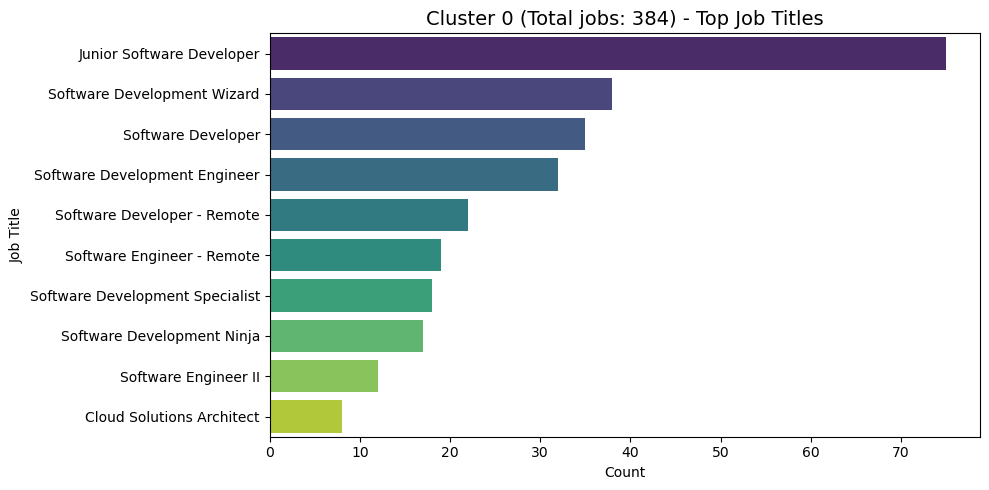

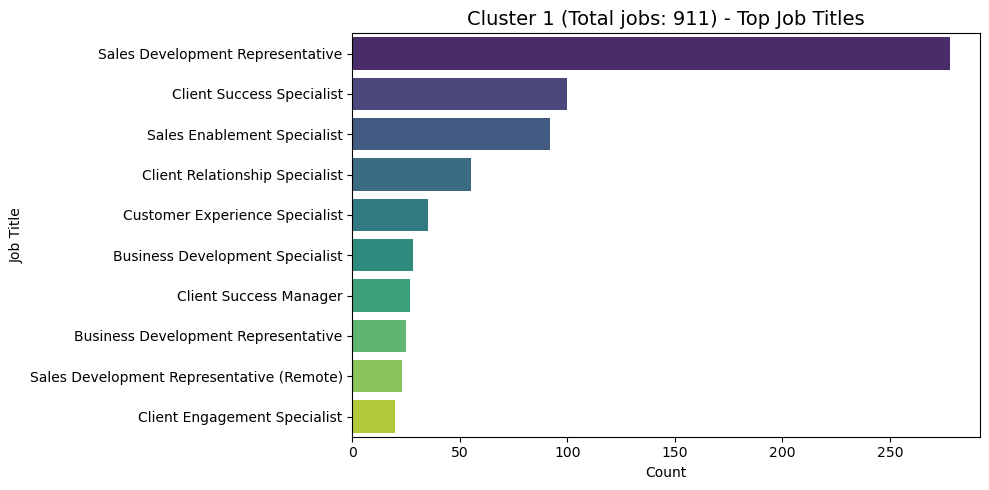

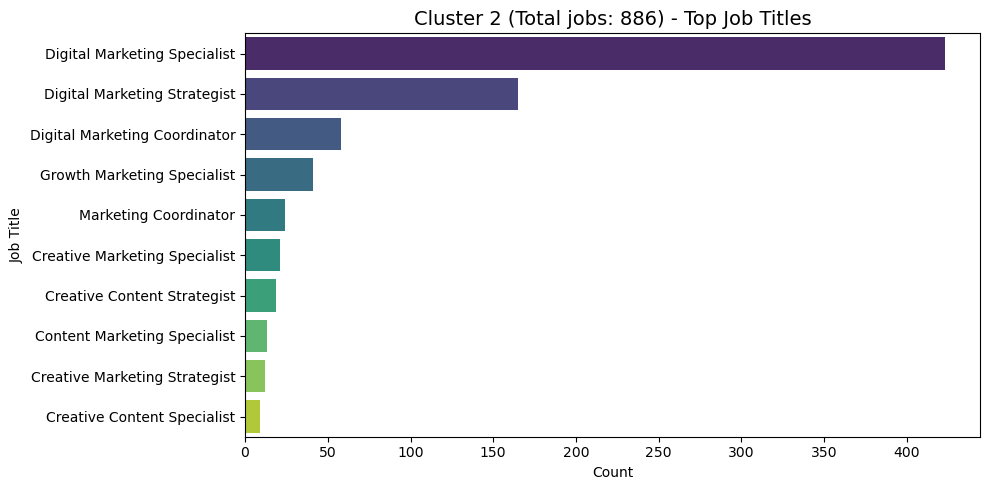

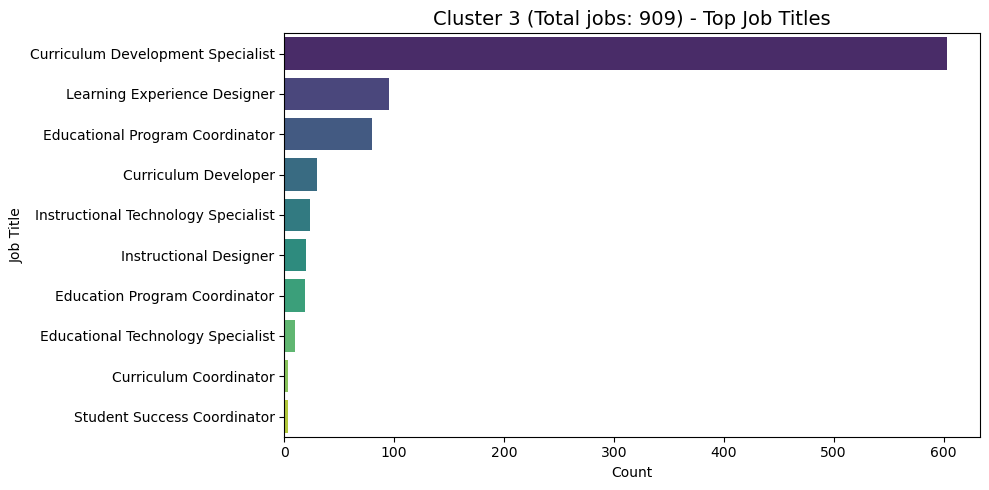

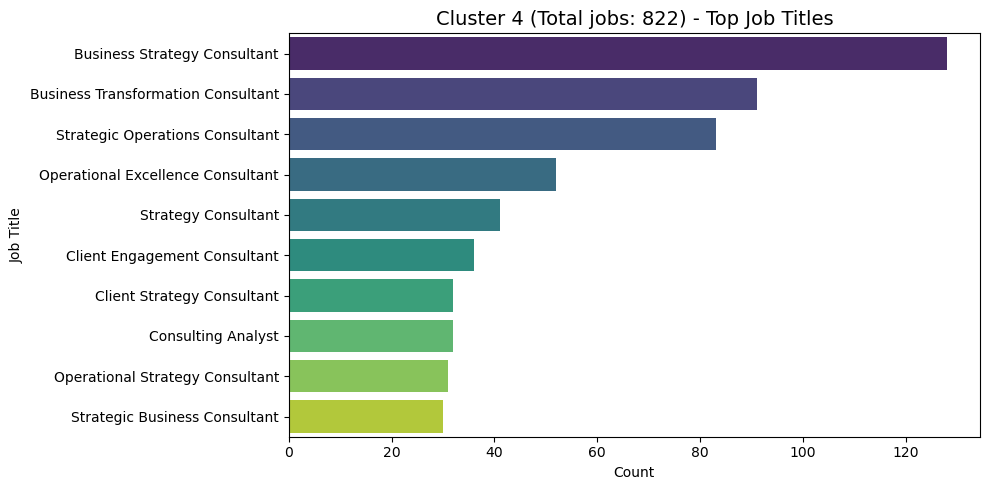

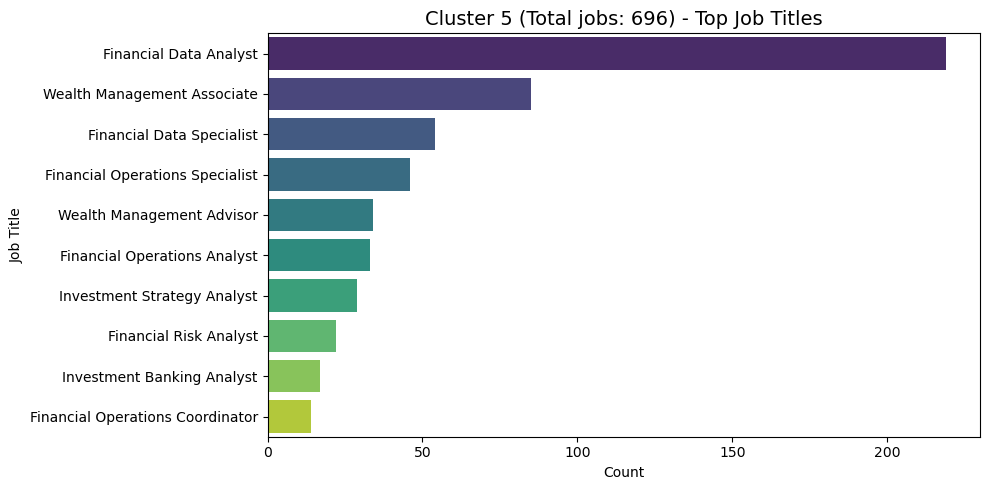

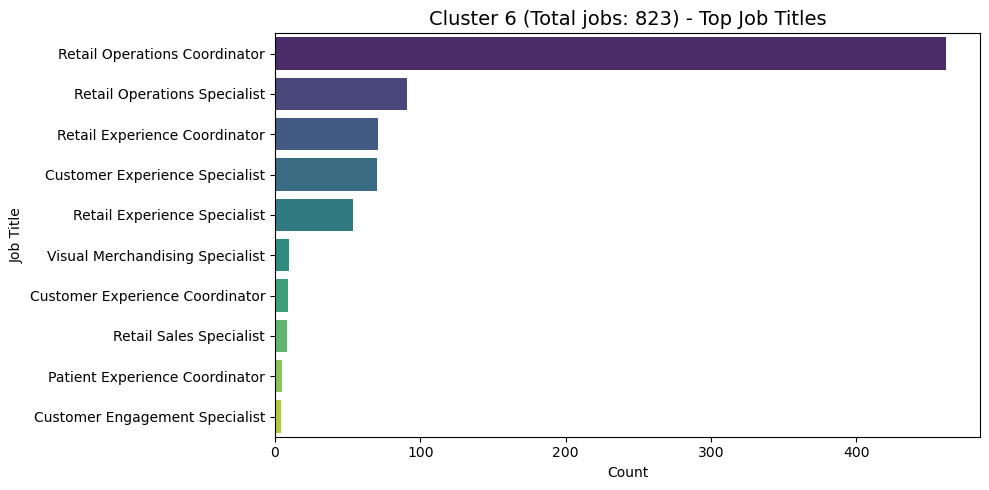

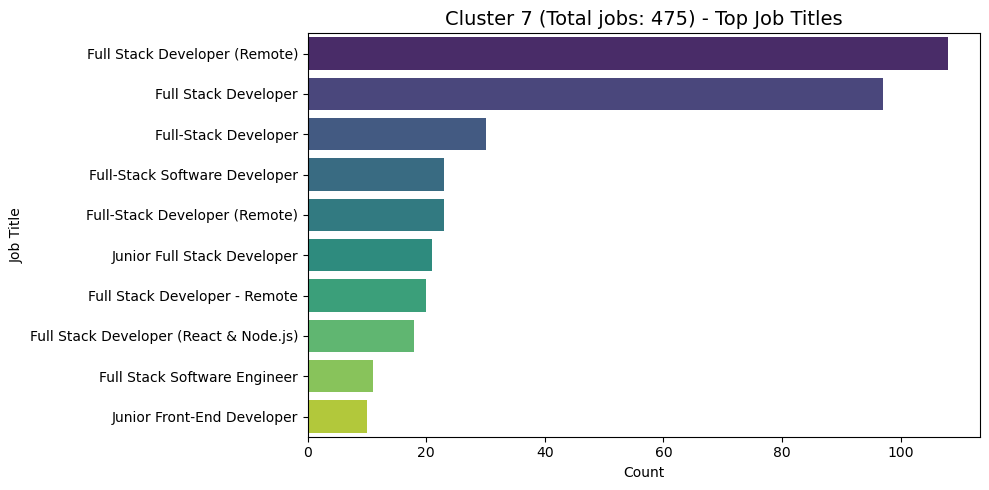

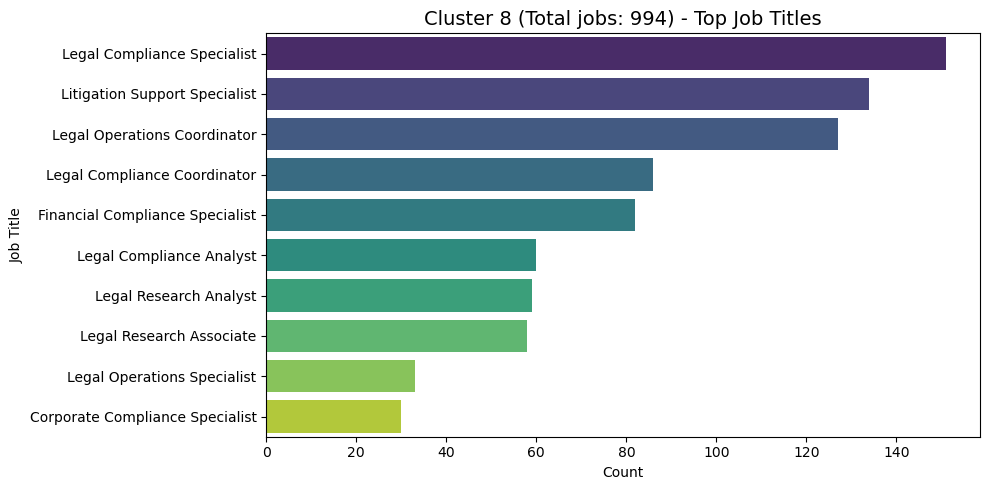

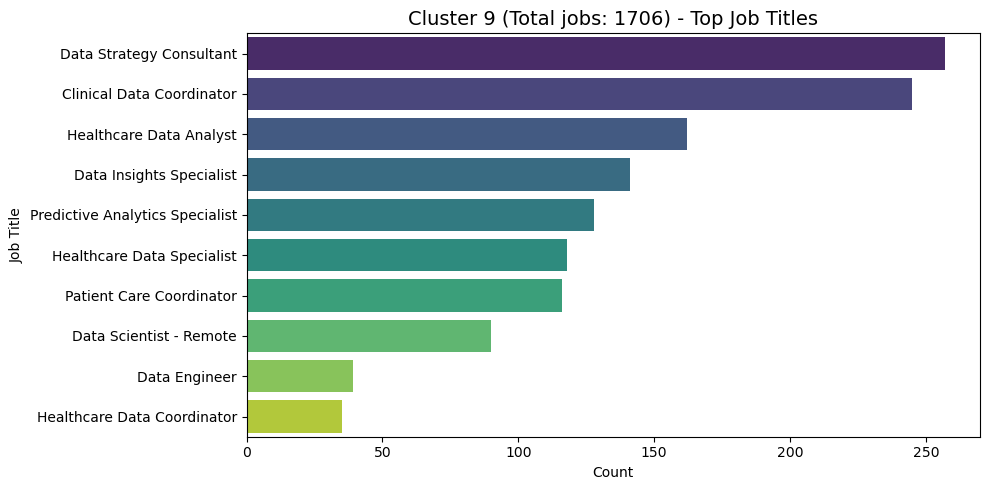

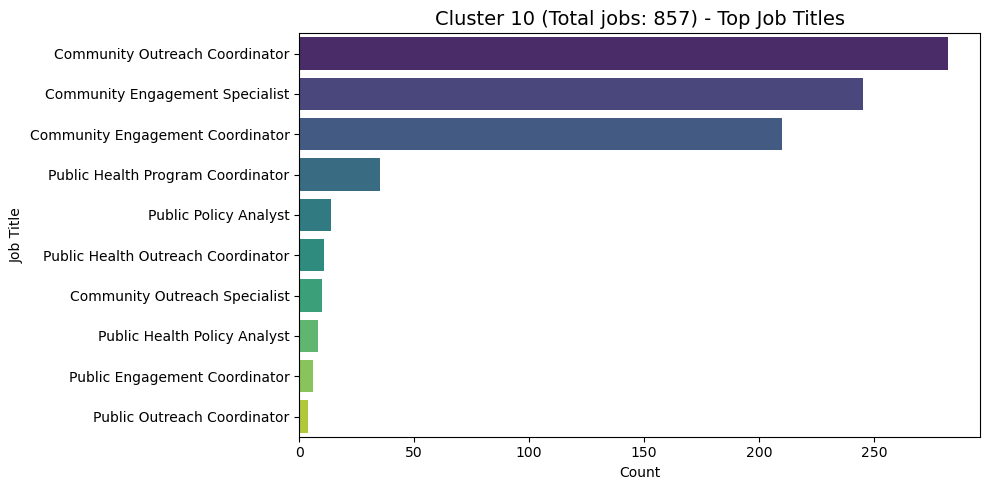

In [20]:
# --------------------------------------
# STEP 3: Analyze Cluster Results
# --------------------------------------
# Top job titles in each cluster
print("🔹 Top 10 most common titles per cluster - K-means using Embedding:")
for i in range(k):
    cluster_df = posting_df[posting_df['kmeans_embed_cluster'] == i]
    total_in_cluster = len(cluster_df)
    
    top_titles = cluster_df['job_title'].value_counts().head(10)

    plt.figure(figsize=(10, 5))
    sns.barplot(x=top_titles.values, y=top_titles.index, palette='viridis', hue=top_titles.index, legend=False)
    plt.title(f"Cluster {i} (Total jobs: {total_in_cluster}) - Top Job Titles", fontsize=14)
    plt.xlabel("Count")
    plt.ylabel("Job Title")
    plt.tight_layout()
    plt.show()

In [21]:
# --------------------------------------
# STEP 4: Compare performance between k-means cluster using TF-IDF vs embeddings
# --------------------------------------
from sklearn.metrics import silhouette_score

# For TF-IDF version
sil_score_tfidf = silhouette_score(X_tfidf, kmeans_tfidf.labels_)
print(f"Silhouette Score (TF-IDF): {sil_score_tfidf:.3f}")

# For embeddings version
sil_score_embed = silhouette_score(embeddings, kmeans_embed.labels_)
print(f"Silhouette Score (Embeddings): {sil_score_embed:.3f}")

Silhouette Score (TF-IDF): 0.157
Silhouette Score (Embeddings): 0.217


### 🔷 Comments on the categorization results with K-means clustering with embeddings

* As shown in the top job titles for each cluster, K-means clustering using **embeddings** does a strong job of grouping similar jobs together based on their semantic content.
* While both approaches — K-means with TF-IDF and K-means with embeddings — produce meaningful clusters, we evaluate their performance more formally using the **silhouette score**.

#### ❓ What is  **silhouette score** 
* The **silhouette score** is a commonly used metric to evaluate the quality of clustering.
* The silhouette score for a point is calculated as the difference between its average distance to points in the nearest other cluster and its own cluster, divided by the maximum of those two distances.
    - For multiple clusters, the **final silhouette score** is the **mean of all** $s(i)$ across the dataset.
* It measures how well each point fits within its assigned cluster compared to other clusters.
* ⚠️ What to take caution of:
    - Silhouette scores **tend to be lower** in high-dimensional data (like TF-IDF), even if clusters are meaningful.
    - It does **not guarantee** that clusters are semantically meaningful or interpretable — qualitative checks (like job titles and top terms) are still necessary.
    - The score can be misleading if the number of clusters (`k`) is too high or too low.

#### ‼️ Takeaway from the results:
- In this case, the **embeddings-based clustering** yields a higher silhouette score, suggesting that clusters formed using embeddings may be more coherent.

---
## SECTION 4: LDA Topic Modeling

In this section, I apply **Latent Dirichlet Allocation (LDA)** to uncover latent topics within job postings.

Unlike K-means clustering — which assigns each job to a **single cluster** — LDA models each job posting as a **probabilistic mixture of multiple topics**.

🔷 **Example:**  
Consider a job posting titled *"Data Science Project Manager"*:
- **K-means** might assign it to just one cluster, such as "Data" or "Management".
- **LDA**, by contrast, might represent it as:
  - **30%** *Data Science*
  - **70%** *Project Management*

This means that LDA does not assign a job to one exclusive category. Instead, it identifies the degree to which a job posting reflects each topic — allowing for **overlapping and interpretable topic distributions**.

As a result, LDA could provide a more flexible and nuanced way to represent job content, especially for postings that span multiple functional areas.


In [24]:
# --------------------------------------
# STEP 1:  Create Dictionary and Corpus
# --------------------------------------
# Create dictionary of terms
dictionary = corpora.Dictionary(tokenized_docs)

# Filter out very rare and very common words
dictionary.filter_extremes(no_below=10, no_above=0.5)
    ## Removing words that appear in fewer than 10 documents -> likely not useful
    ## Removing words that appear in more than 50% of documents -> Likely too generic (e.g. "job", "position")

# Create the Bag-of-Words corpus
corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]
    ## Each job posting becomes a list of (word_id, word_count) pairs 


In [25]:
len(corpus)  ## Length of corpus => # of job postings

9463

In [26]:
# corpus[0] ## Checking corpus for the first job posting 

In [27]:
# --------------------------------------
# STEP 2: Fit LDA
# --------------------------------------
from gensim.models import LdaModel

lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=10,  
    passes=10,      # More passes = better learning, but slower 
    random_state=42
)

#    "lda_model" object contains the following features: 
#        * View topics: lda_model.print_topics(num_words=10)       => Shows top 10 words for each topic 
#        * Get topic distribution for a doc: lda_model[corpus[0]]  => Gives topic probabilities for the first document 
#        * Infer topics for new docs: lda_model[dictionary.doc2bow(new_tokens)]  => Estimate topic mix for a new job posting

In [28]:
# --------------------------------------
# Step 3: Print the Topics
# --------------------------------------
# View top 10 words for each topic
topics = lda_model.print_topics(num_words=10)
for i, topic in topics:
    print(f"Topic {i}: {topic}")


Topic 0: 0.062*"operation" + 0.046*"customer" + 0.026*"store" + 0.022*"management" + 0.019*"coordinator" + 0.018*"enhance" + 0.016*"assist" + 0.015*"environment" + 0.015*"sale" + 0.015*"inventory"
Topic 1: 0.028*"support" + 0.027*"patient" + 0.023*"coordinator" + 0.023*"manage" + 0.022*"specialist" + 0.017*"healthcare" + 0.016*"care" + 0.014*"case" + 0.014*"service" + 0.014*"assist"
Topic 2: 0.044*"sale" + 0.022*"application" + 0.018*"software" + 0.017*"developer" + 0.015*"development" + 0.012*"technology" + 0.012*"code" + 0.011*"design" + 0.010*"javascript" + 0.010*"value"
Topic 3: 0.075*"curriculum" + 0.038*"design" + 0.035*"education" + 0.035*"development" + 0.027*"student" + 0.024*"specialist" + 0.018*"educator" + 0.018*"learn" + 0.017*"material" + 0.015*"technology"
Topic 4: 0.124*"data" + 0.023*"healthcare" + 0.020*"analyze" + 0.016*"analysis" + 0.016*"analyst" + 0.015*"report" + 0.013*"insight" + 0.013*"proficiency" + 0.012*"health" + 0.012*"support"
Topic 5: 0.098*"compliance" 

### 🔷 Notes about the extracted LDA topics 

Above results show that each LDA topic can be roughly categorized as follows.

| Topic # |  Label             | Top Keywords                                                                 |
|---------|-----------------------------|------------------------------------------------------------------------------|
| 0       | **Retail Operations**           | operation, customer, store, management, coordinator, enhance, assist, environment, sale, inventory |
| 1       | **Patient Support**             | support, patient, coordinator, manage, specialist, healthcare, care, case, service, assist |
| 2       | **Software Development**  | application, software, developer, development, technology, code, design, javascript, value |
| 3       | **Curriculum & Education**      | curriculum, design, education, development, student, specialist, educator, learn, material, technology |
| 4       | **Healthcare Data Analysis**    | data, healthcare, analyze, analysis, analyst, report, insight, proficiency, health, support |
| 5       | **Legal & Compliance**          | compliance, conduct, law, prepare, research, management, report, risk, finance, audit |
| 6       | **Business Consulting**         | client, business, strategy, consultant, management, identify, drive, help, conduct, consult |
| 7       | **Data Analytics**              | data, analytics, business, insight, power, strategy, python, drive, trend, visualization |
| 8       | **Digital Marketing**           | marketing, medium, campaign, strategy, brand, analytics, specialist, google, drive, performance |
| 9       | **Community Outreach**          | community, outreach, engagement, program, coordinator, medium, organize, event, enhance, health |


In [68]:
## Checking how lda_model works for the first corpus (for first job posting)
lda_model[corpus[5]]

[(0, 0.08081105), (4, 0.08594847), (6, 0.76492006), (7, 0.059866853)]

As shown above, `lda_model[corpus[5]]` checks the topic distribution for job posting #5. Remember that `corpus[i]` contains a list of (word_id, word_count) pairs for the corresponding job posting. 

It shows that the job posting #5 is comprised of 8.5% of Topic 4  + 76.5 of Topic 6 + etc. Hence, the most dominant topic for this job posting is Topic 6. 

Below, I extract the most dominant topic and the associated probability for each and every job posting. 

In [32]:
# --------------------------------------
# Step 4: Assign each job to a most dominant topic
# --------------------------------------
# Get dominant topic and probability for each document
dominant_topics = []
topic_probs = []

for bow in corpus:
    topic_dist = lda_model[bow]  # Get topic distribution

    # Exclude topic 2 (which is the topic for diversity statement) 
    filtered_dist = [(tid, prob) for tid, prob in topic_dist if tid != 2]
    
    # If everything got filtered (rare), fallback to original dist
    if not filtered_dist:
        filtered_dist = topic_dist

    # Sort by probability
    sorted_topics = sorted(filtered_dist, key=lambda x: -x[1])

    # Store most dominant (non-topic-2) topic and its probability
    dominant_topics.append(sorted_topics[0][0])
    topic_probs.append(sorted_topics[0][1])


# Assign to jobs_df
posting_df["lda_topic_1st"] = dominant_topics
posting_df["lda_topic_1st_prob"] = topic_probs

In [33]:
posting_df["lda_topic_1st"].value_counts(dropna=False).sort_index()

lda_topic_1st
0    1012
1     559
2     496
3     963
4    1200
5     857
6    1561
7     919
8     998
9     898
Name: count, dtype: int64

Below, I store the full topic probability distribution for each document. 

I will generate a column for each topic i (jobs_df["Topic {i}"]) in the jobs_df dataframe. This column will store the percentage of the corresponding topic for each job posting. 

In [35]:
# --------------------------------------
# Step 5: Store full topic probability distributions for each document
# --------------------------------------
all_topic_dists = []

for bow in corpus:
    topic_dist = lda_model[bow]  # list of (topic_id, prob)
    full_dist = [0.0] * lda_model.num_topics  # initialize all probabilities to 0
    for topic_id, prob in topic_dist:
        full_dist[topic_id] = prob  # fill in non-zero values
    all_topic_dists.append(full_dist)

# To assign as new column in jobs_df ...

# First create "topic_df" that convers all_topic_dists to a dataframe with columns (Topic 1, Topic 2, ... )
topic_cols = [f"topic_{i}" for i in range(lda_model.num_topics)]
topic_df = pd.DataFrame(all_topic_dists, columns=topic_cols)

# Concatenate with original DataFrame
posting_df = pd.concat([posting_df.reset_index(drop=True), topic_df], axis=1)

### SECTION 4.1: Visualize the distribution of topics 

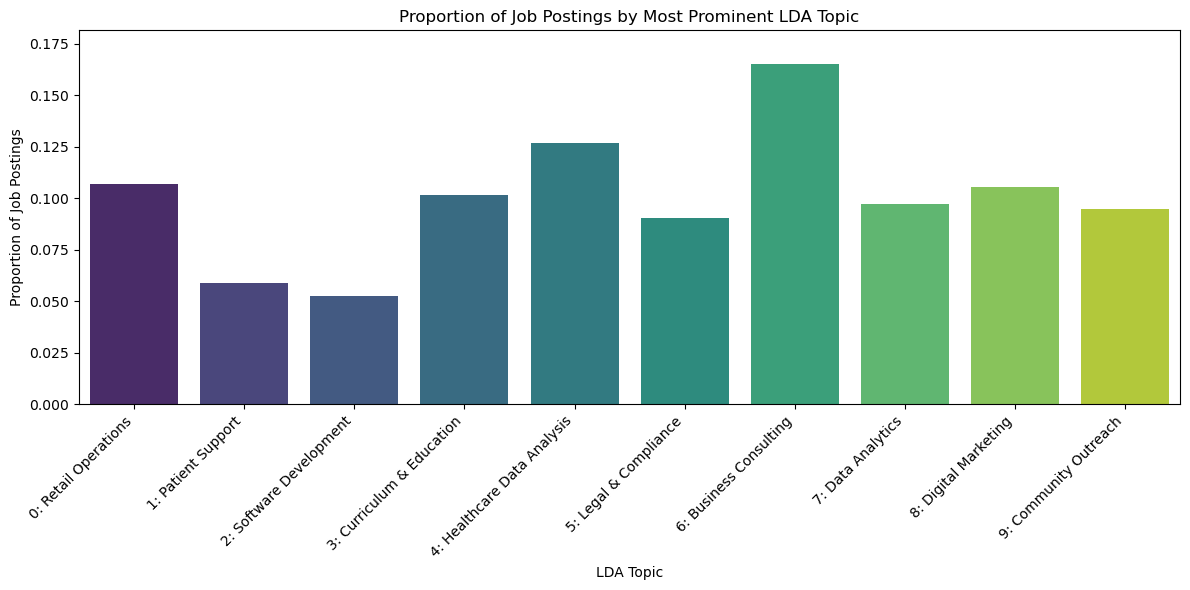

In [86]:
# --------------------------------------
# Step 1: Most common topic (only dominant ones) per posting 
# --------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Define topic labels excluding topic 2
topic_labels_filtered = {
    0: "0: Retail Operations",
    1: "1: Patient Support",
    2: "2: Software Development",
    3: "3: Curriculum & Education",
    4: "4: Healthcare Data Analysis",
    5: "5: Legal & Compliance",
    6: "6: Business Consulting",
    7: "7: Data Analytics",
    8: "8: Digital Marketing",
    9: "9: Community Outreach",
}

# Count topic frequencies and normalize to proportions
topic_counts = posting_df["lda_topic_1st"].value_counts(normalize=True).sort_index()

# Create DataFrame for plotting
topic_df = topic_counts.reset_index()
topic_df.columns = ["topic_id", "proportion"]
topic_df["label"] = topic_df["topic_id"].map(topic_labels_filtered)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    x="label", 
    y="proportion", 
    data=topic_df, 
    palette="viridis",  
    hue="label", 
legend=False)

plt.title("Proportion of Job Postings by Most Prominent LDA Topic")
plt.xlabel("LDA Topic")
plt.ylabel("Proportion of Job Postings")
plt.xticks(rotation=45, ha="right")
plt.ylim(0, topic_df["proportion"].max() * 1.1)

plt.tight_layout()
plt.show()



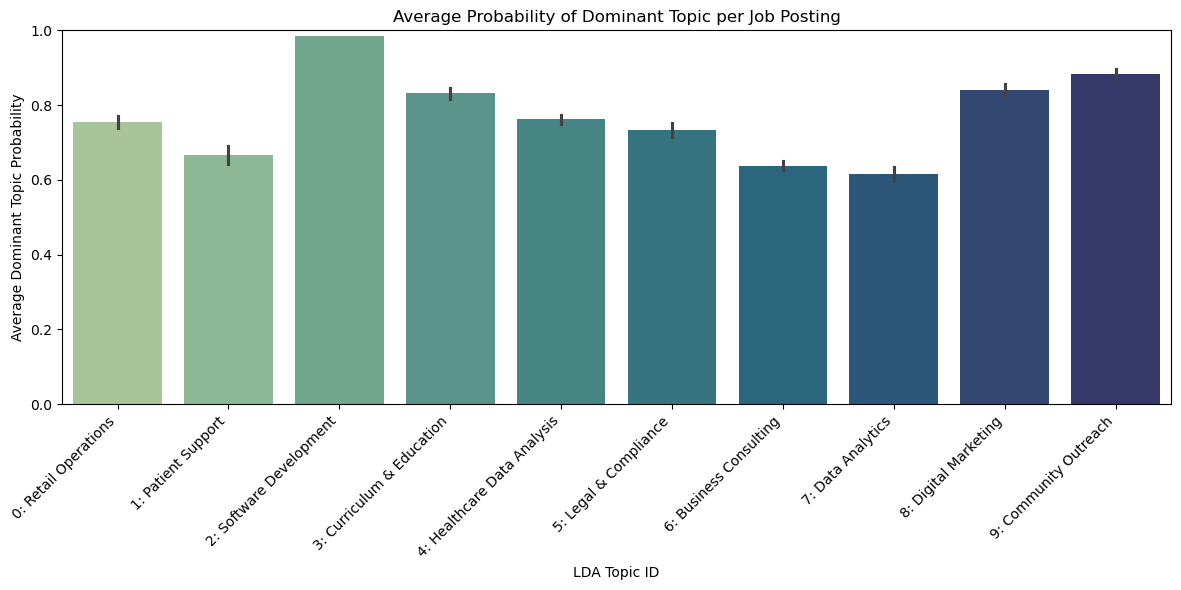

In [88]:
# --------------------------------------
# Step 2: Average topic probability for the most dominant topics
# --------------------------------------
plt.figure(figsize=(12, 6))
sns.barplot(
    x="lda_topic_1st",
    y="lda_topic_1st_prob",
    data=posting_df,
    estimator='mean',
    palette="crest",  
    hue="lda_topic_1st", 
    legend=False
)
plt.title("Average Probability of Dominant Topic per Job Posting")
plt.xlabel("LDA Topic ID")
plt.ylabel("Average Dominant Topic Probability")
plt.ylim(0, 1)

# Sort x labels to match actual plotted categories
sorted_topic_ids = sorted(posting_df["lda_topic_1st"].dropna().unique())
plt.xticks(
    ticks=range(len(sorted_topic_ids)),
    labels=[topic_labels_filtered[tid] for tid in sorted_topic_ids],
    rotation=45,
    ha='right'
)
plt.tight_layout()
plt.show()

## 🔷 Evaluate the quality of topics 

Coherence measures how interpretable the topics are by quantifying the semantic similarity of the top words in each topic.
* High coherence ⇒ Top words in each topic tend to co-occur in the corpus and form meaningful groups.
* Low coherence ⇒ Top words are disjoint or random.

**How to Interpret the Score**
* Ranges from 0 to 1
* Rough guidelines:
    * 0.6–0.7: Moderate coherence
    * 0.7–0.85: Good
    * 0.85+: Very coherent topics (rare in messy text data)


In [84]:
## Evaluate Coherence (Quality of Topics)
os.environ["TOKENIZERS_PARALLELISM"] = "false"
from gensim.models import CoherenceModel

coherence_model = CoherenceModel(
    model=lda_model,
    texts=tokenized_docs,
    dictionary=dictionary,
    coherence='c_v'
)

print("Coherence Score:", coherence_model.get_coherence())


Coherence Score: 0.6686584763083092
